# En esta parte del proyecto nos dedicaramos a la parte del EDA

Ya que tenemos nuevos datos limpios para poder investigar. Empezaremos a analizarlos primero con el total de reseñas positivas del juego original y de sus secuela/s.
Despues de este proceso, lo haremos con el porcentaje total de reseñas para ver como cambia los datos. Esto para ver alguna si hay alguna diferencia

Seran dos pasos ya que son dos perspectivas que se puede apreciar el exito de una entrega.

**De ante mano decir** que este data frame que se estara utilizando ya limpio previamente el outlier mas alto que estaba en el csv original, esto fue para ahorrar tiempo.
***
## Librerias y procesar el archivo
**Primeramente cargamos las librerias para despues cargar el archivo hecho en el ETL**


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
import re
import seaborn as sns
from pathlib import Path

In [7]:
# Abro el archivo csv

with open("data/df_limpio_sin_outlier_resenas.csv", "r", encoding="utf-8") as f:
    df_final = pd.read_csv(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/df_limpio_sin_outlier_resenas.csv'

In [ ]:
df_final.head()

,Franquicia_Base,Secuela_Nombre,Secuela_Año,Secuela_Reseñas_Positivas,Secuela_Reseñas_Negativas,Secuela_Pct_Positivo,Original_Nombre,Original_Año,Original_Reseñas_Positivas,Original_Reseñas_Negativas,Original_Pct_Positivo,Años_Diferencia,Cambio_Pct_Calidad,Ratio_Popularidad_vs_Original
0,12 labours of hercules,12 Labours of Hercules II: The Cretan Bull,2015,1867,208,90,12 Labours of Hercules,2015,2814,192,93,0,-3,69.03
1,9nine,9-nine-:Episode 2,2019,1491,23,98,9-nine-:Episode 1,2019,1461,73,95,0,3,98.70
2,9nine,9-nine-:Episode 4,2021,1089,20,98,9-nine-:Episode 1,2019,1461,73,95,2,3,72.29
3,a plague tale,A Plague Tale: Requiem,2022,17807,1721,91,A Plague Tale: Innocence,2019,58010,4066,93,3,-2,31.46
4,a space for the unbound,A Space for the Unbound,2023,5674,140,97,A Space For The Unbound - Prologue,2020,1276,24,98,3,-1,447.23


***
## Graficamos el data frame

Graficamos el df para ver su comportamiento. Esto lo hacemos con la premisia de que la secuela de un juego es mejor si este tiene mas reseñas positivas en total que el juego original.


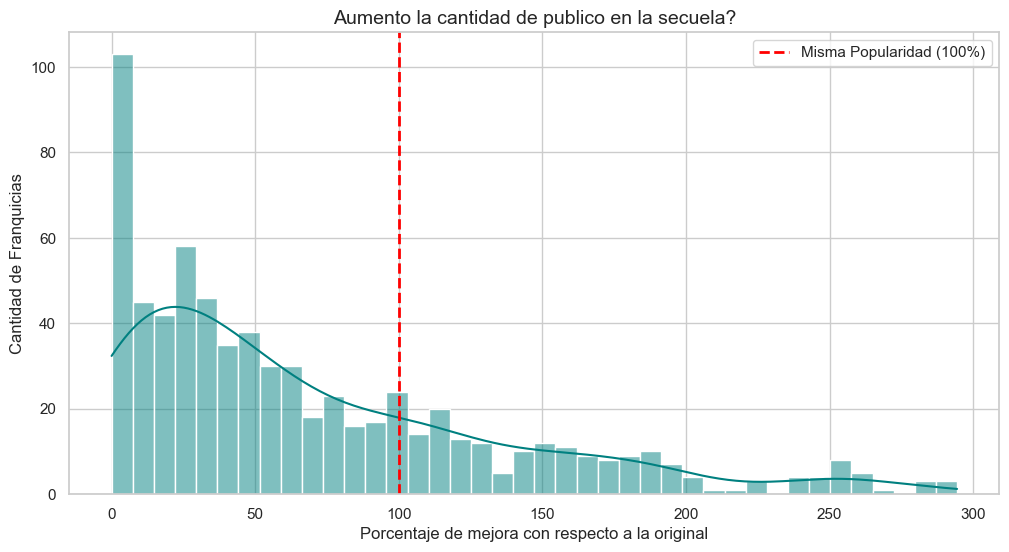

In [ ]:
# Creamos un histograma
sns.set_theme(style="whitegrid")

# Esto maneja de mejor manera los outliers
data_grafico = df_final[df_final['Ratio_Popularidad_vs_Original'] <= 300]

plt.figure(figsize=(12, 6))
sns.histplot(data=data_grafico, x='Ratio_Popularidad_vs_Original', kde=True, bins=40, color='teal')

# Creo una linea roja que identifique cuando cambia de popularidad
plt.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Misma Popularidad (100%)')

plt.title('Aumento la cantidad de publico en la secuela?', fontsize=14)
plt.xlabel('Porcentaje de mejora con respecto a la original', fontsize=12)
plt.ylabel('Cantidad de Franquicias', fontsize=12)
plt.legend()
plt.show()

**Si los datos estan a la derecha de la linea roja. Entonces son mas "populares" que el juego original, ya que vendieron mas copias que el original. Ignorando si son reseñas negativas o positivas. Si esta a la izquierda es lo contrario**

se puede ver que la mayoria de las secuelas son mucho peores que los juegos originales

***

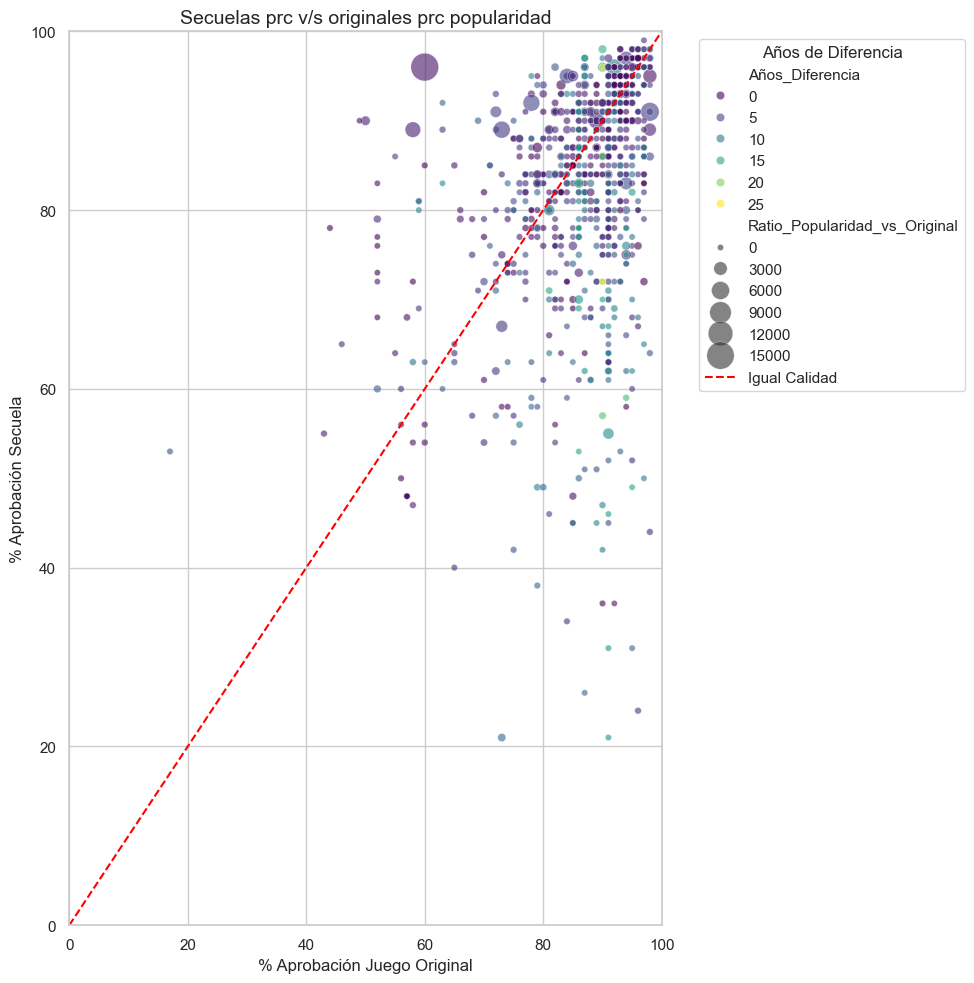

In [ ]:
# Hago un scatter plot comparando la calidad de los juegos
plt.figure(figsize=(10, 10))

# Pongo las columnas que sirven para ver la popularidad y tiempo
sns.scatterplot(
    data=df_final,
    x='Original_Pct_Positivo',
    y='Secuela_Pct_Positivo',
    size='Ratio_Popularidad_vs_Original', # Modifica el tamaño de los puntos
    sizes=(20, 400),
    alpha=0.6,
    palette='viridis',
    hue='Años_Diferencia' 
)

# Otra linea que divide las secuelas en malas y buenas
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Igual Calidad')

plt.title('Secuelas prc v/s originales prc popularidad', fontsize=14)
plt.xlabel('% Aprobación Juego Original', fontsize=12)
plt.ylabel('% Aprobación Secuela', fontsize=12)
plt.legend(title='Años de Diferencia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

***
### Exitos de las secuelas comparados con la original
Vere los tipos de fracaso que pueden aver dependiendo del punto de vista que tengas.
- Corporativo
- Programador

En el Corporativo se considerara que fue un fracaso la secuela si esta no supero en ventas a la secuela y el programador si el porcentaje de reseñas positivas disminuyo.

In [8]:
# Aqui calculamos los parametros para considerar si fue un fracaso o exito
total_original = df_final['Original_Reseñas_Positivas'] + df_final['Original_Reseñas_Negativas']
total_secuela = df_final['Secuela_Reseñas_Positivas'] + df_final['Secuela_Reseñas_Negativas']

df_final['Resultado_Ventas'] = df_final.apply(
    lambda row: 'Éxito (Superó al Original)' 
    if (row['Secuela_Reseñas_Positivas'] + row['Secuela_Reseñas_Negativas']) > (row['Original_Reseñas_Positivas'] + row['Original_Reseñas_Negativas']) 
    else 'Fracaso (No superó al Original)', axis=1
)

df_final['Resultado_Calidad'] = df_final['Cambio_Pct_Calidad'].apply(
    lambda x: 'Mejoró o Igual (>= 0%)' if x >= 0 else 'Empeoró (< 0%)'
)

# Grafico corporativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Vemos la columna de ventas
conteo_ventas = df_final['Resultado_Ventas'].value_counts()

colores_ventas = ['#ff9999' if 'Fracaso' in label else '#66b3ff' for label in conteo_ventas.index]

ax1.pie(conteo_ventas, labels=conteo_ventas.index, autopct='%1.1f%%', 
        startangle=90, colors=colores_ventas, explode=(0.05, 0), shadow=True)
ax1.set_title('Exitos medidos en la cantidad de ventas en comparacion a la primera entrega\nCorporativo', fontsize=14, fontweight='bold')



# Grafico de Programador 
conteo_calidad = df_final['Resultado_Calidad'].value_counts()

# Colores: Rojo para empeoró, Verde para mejoró
colores_calidad = ['#99ff99' if 'Mejoró' in label else '#ff9999' for label in conteo_calidad.index]

ax2.pie(conteo_calidad, labels=conteo_calidad.index, autopct='%1.1f%%', 
        startangle=90, colors=colores_calidad, explode=(0.05, 0), shadow=True)
ax2.set_title('La critica al juego mejoro (% Resivimiento positivo)\nProgramador', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'df_final' is not defined

- En vista de la pespectiva corporativa, es muy comun que las secuelas no alcancen en ventas a la primera entrega de la franquicia.
- En el "Programador", tambien es normal que tu producto no sea muy bien resivido en comparacion al primero, resiviendo mas criticas de pormedio. Aunque menos probable que en las ventas.
***
## Comparando varias variables para considerar exitoso el juego:

In [119]:
#Codigo nescesario para ejecutar el siguiente grafico
df_final['Total_Original'] = df_final['Original_Reseñas_Positivas'] + df_final['Original_Reseñas_Negativas']
df_final['Total_Secuela'] = df_final['Secuela_Reseñas_Positivas'] + df_final['Secuela_Reseñas_Negativas']

# Esta funciona calcula varios parametros para definir el exito de las secuelas
def cat_ventas(row):
    if row['Total_Secuela'] >= row['Total_Original']:
        return 'Superó Ventas Originales'
    elif row['Total_Secuela'] >= (row['Total_Original'] * 0.5):
        return 'Declive (50% - 100% del Orig)'
    else:
        return 'Fracaso Comercial (<50% del Orig)'

df_final['Estado_Ventas'] = df_final.apply(cat_ventas, axis=1)

df_final['Estado_Calidad'] = np.where(
    df_final['Secuela_Pct_Positivo'] >= df_final['Original_Pct_Positivo'], 
    'Mejoró o Igual Calidad', 
    'Empeoró Calidad'
)

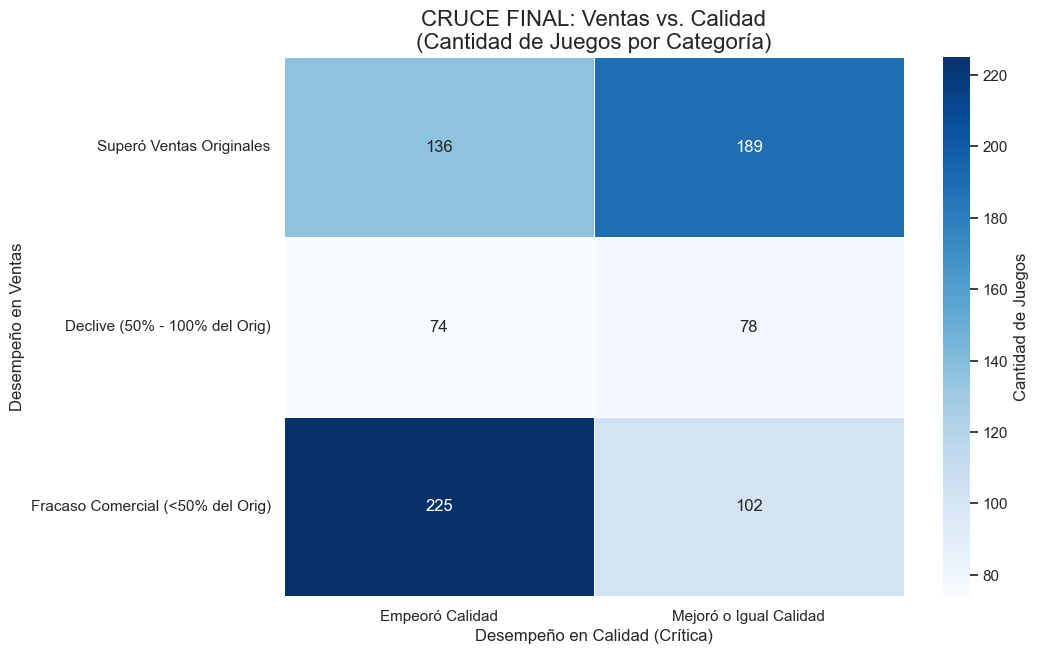

In [120]:
matriz = pd.crosstab(df_final['Estado_Ventas'], df_final['Estado_Calidad'])

# Hacemos un reordenamiento de la visualizacion de los datos
order_index = ['Superó Ventas Originales', 'Declive (50% - 100% del Orig)', 'Fracaso Comercial (<50% del Orig)']
matriz = matriz.reindex(order_index)

plt.figure(figsize=(10, 7))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={'label': 'Cantidad de Juegos'})

plt.title('CRUCE FINAL: Ventas vs. Calidad\n(Cantidad de Juegos por Categoría)', fontsize=16)
plt.ylabel('Desempeño en Ventas', fontsize=12)
plt.xlabel('Desempeño en Calidad (Crítica)', fontsize=12)

plt.show()

Aqui se puede apreciar mucho mejor el tipo de fracaso que puede tener la futura secuela, dependiendo de los parametros que consideres importantes. En este caso estan todos los parametros. Y no simplificados visto en los graficos de torta.

***
# Conclusion primer vistazo :
Basado en los datos dados por la API mencionada en el ETL y con una limpieza de datos en la que tiene mucho margen de error al no registrar todos los titulos y franquicias (Pero no se equiboca al poner el juego en la franquicia). Estos son los datos recopilados:

- **Con una perspectiva del mundo corporativo:** La mayoria de los juegos sacados en steam y que son una franquicia tienen perdidas monetarias. Ya que el **60.6%** de las secuelas fracasan, y es poco probable sacar una secuela que supere en ventas al primer juego.

- **Con una perspectiva del mundo Programador/Amor al arte:** Tiene una significativa mejora en el exito comparado a las ventas de los juegos (Medidas en la cantidad de reseñas totales. Esto es el mejor estimado de las cantidad de ventas). Pero aun asi con esta mejora, Tiene una alta probabilidad de fracasar y que a los fans de la saga esten decepcionados con la secuela, y que representen este contento en las malas reseñas que dejan en steam y con una posible caida de ventas en ese juego (Dado a tener menos reseñas positivas).

Queda claro que por los numeros visto, sacar una secuelad de alguna saga/franquicia es muy probablemente un fracaso financiero como en critica. Esto ultimo puede estar conectado con las ventas del producto. Hacer secuelas de juego es un negocio que no perdona y que probablemente fracases. Pero, porque?

Esta pregunta la estaremos intentando resolver con tecnicas de prediccion u otras herramientas.